# Ranking Algorithm P2
This document finalises our results

In [1]:
# libraries 
from pyspark.sql import SparkSession, functions as F
from pyspark.ml import feature as H
from operator import add
from functools import reduce

In [2]:
def open_spark():
    # First lets reed the datasets
    spark = (
        SparkSession.builder.appName("Data_Explorer")
        .config("spark.sql.repl.eagerEval.enabled", True) 
        .config("spark.sql.parquet.cacheMetadata", "true")
        .config("spark.sql.session.timeZone", "Etc/UTC")
        .config("spark.driver.memory", "4g")
        .getOrCreate())
    return spark

In [3]:
spark = open_spark()

22/10/16 12:40:39 WARN Utils: Your hostname, James-N580VD-DM229T resolves to a loopback address: 127.0.1.1; using 172.31.83.34 instead (on interface eth0)
22/10/16 12:40:39 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/16 12:40:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# This function is used to apply the minimising scoring process for a certain metric
# This time 0 [best] - 1 [worst]
def scroring_process(dataset):
    # first subtract 1 from each cell then square
    for col in dataset.columns[1:]:
        dataset = dataset.withColumn(col, F.pow((F.col(col) - 1),2))
    # sum the columns 
    dataset = dataset.withColumn('total',F.round(reduce(add, [F.col(x) for x in dataset.columns[1:]]), 8))
    return dataset

# Define our scaling transfomration function, resulting in attributes ranked within 0 [worst] - 1 [best]
def feature_standardisation(dataset): 
    values = dataset.select(F.max('total').alias('high'), F.min('total').alias('low'))
    dataset = dataset.withColumn('total', F.round((F.col('total') - values.select('low').head()[0]) / (values.select('high').head()[0] - values.select('low').head()[0]), 9))
    return dataset.select('merchant_abn', 'total')

In [5]:
def main():
    # Read all our tables 
    customer_scaled = spark.read.parquet('../data/Normalised/customer_scaled1/')
    customer_scaled = customer_scaled.fillna(0.5)
    industry_scaled = spark.read.parquet('../data/Normalised/industry_scaled1/')
    industry_scaled = industry_scaled.fillna(0.5)
    # need to remove sector name and store in lookup 
    sector_lookup = industry_scaled.select('merchant_abn', 'sector')
    industry_scaled = industry_scaled.drop('sector')
    sustainability_scaled = spark.read.parquet('../data/Normalised/sustainability_scaled1/')
    sustainability_scaled = sustainability_scaled.fillna(0.5)
    revenue_scaled = spark.read.parquet('../data/Normalised/revenue_scaled1/')
    revenue_scaled = revenue_scaled.fillna(0.5)
    # score industry, then add to sustainability
    industry_scaled = scroring_process(industry_scaled)
    industry_scaled = industry_scaled.select('merchant_abn','total')
    industry_scaled = feature_standardisation(industry_scaled)
    industry_scaled = industry_scaled.withColumnRenamed('total','Industry_score')
    sustainability_scaled = sustainability_scaled.join(industry_scaled, on='merchant_abn', how='left')
    # Scale all metrics now
    customer_scaled = scroring_process(customer_scaled)
    sustainability_scaled = scroring_process(sustainability_scaled)
    revenue_scaled = scroring_process(revenue_scaled)
    # Now equally combine them to get the final merchant score 
    customer_scaled = customer_scaled.select('merchant_abn','total')
    customer_scaled = feature_standardisation(customer_scaled)
    customer_scaled = customer_scaled.withColumnRenamed('total','Customer_score')
    revenue_scaled = revenue_scaled.select('merchant_abn','total')
    revenue_scaled = feature_standardisation(revenue_scaled)
    revenue_scaled = revenue_scaled.withColumnRenamed('total','Revenue_score')
    sustainability_scaled = sustainability_scaled.select('merchant_abn','total')
    sustainability_scaled = feature_standardisation(sustainability_scaled)
    sustainability_scaled = sustainability_scaled.withColumnRenamed('total','Sustainability_score')
    # Finally join 
    Full_scores = customer_scaled.join(revenue_scaled, on='merchant_abn', how='inner').join(sustainability_scaled, on='merchant_abn', how='inner')
    Full_scores = Full_scores.withColumn('Merchant_score',F.round(reduce(add, [F.col(x) for x in Full_scores.columns[1:]]), 8))
    Full_scores = Full_scores.join(sector_lookup, on='merchant_abn', how='inner')
    Full_scores.write.parquet('../data/Normalised/Final_scores_alt1', mode='overwrite')

In [6]:
main()

In [7]:
variation = spark.read.parquet('../data/Normalised/Final_scores_alt1/')

In [8]:
variation.groupby('sector').count()

sector,count
Arts_Recreation_S...,1095
Administrative_Su...,539
Information_Media...,876
Personal_Services,1498


For determining the top merchant 

In [18]:
spark.read.parquet('../data/Normalised/industry_scaled/')

sector,merchant_abn,Portion_of_Total_Revenue,Portion_of_Total_Transactions,Average_Weighted_Revenue,survival_rate
Administrative_Su...,23305324752,0.0,0.0,0.8025,0.0
Administrative_Su...,17266923036,0.0,0.0,0.8025,0.0
Administrative_Su...,11633090957,0.0,0.0,0.8025,0.0
Administrative_Su...,22718657980,0.0,0.0,0.8025,0.0
Administrative_Su...,68112267199,0.0,0.0,0.8025,0.0
Administrative_Su...,86670100004,0.0,0.0,0.8025,0.0
Administrative_Su...,96885194635,0.0,0.0,0.8025,0.0
Administrative_Su...,36555094223,0.0,0.0,0.8025,0.0
Administrative_Su...,55193751157,0.0,0.0,0.8025,0.0
Administrative_Su...,90173050473,0.0,0.0,0.8025,0.0


In [9]:
Full_scores = spark.read.parquet('../data/Normalised/Final_scores_alt/')

In [10]:
Full_scores.groupBy('sector').count()

sector,count
Arts_Recreation_S...,1109
Administrative_Su...,466
Information_Media...,1028
Personal_Services,1405


In [11]:
merchant = spark.read.parquet('../data/processed/merchants/')

Text(0, 0.5, 'Frequency of Merchants')

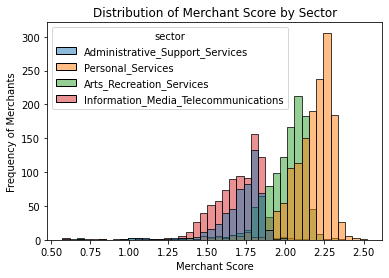

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(x='Merchant_score', hue='sector', data=variation.toPandas())
plt.title('Distribution of Merchant Score by Sector')
plt.xlabel('Merchant Score')
plt.ylabel('Frequency of Merchants')

Text(0, 0.5, 'Frequency of Merchants')

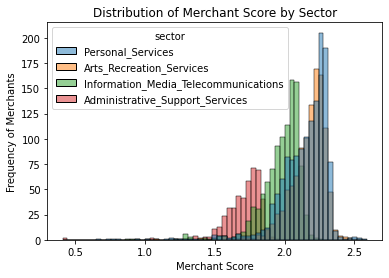

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(x='total', hue='sector', data=Full_scores.toPandas())
plt.title('Distribution of Merchant Score by Sector')
plt.xlabel('Merchant Score')
plt.ylabel('Frequency of Merchants')


In [ ]:
top_100 = Full_scores.orderBy('total').limit(100)

In [ ]:
top_100_pd = top_100.groupBy('sector').count().toPandas()
top_100_pd

,sector,count
0,Administrative_Support_Services,46
1,Personal_Services,25
2,Information_Media_Telecommunications,24
3,Arts_Recreation_Services,5


In [ ]:
top_100 = variation.orderBy('Merchant_score').limit(100)
top_100_pd = top_100.groupBy('sector').count().toPandas()
top_100_pd

,sector,count
0,Information_Media_Telecommunications,49
1,Arts_Recreation_Services,16
2,Administrative_Support_Services,25
3,Personal_Services,10


In [ ]:
# library
import matplotlib.pyplot as plt
import seaborn as sns
# create data
names = ['Personal_Services', 'Arts_Recreation_Services', 'Information_Media_Telecommunications', 'Administrative_Support_Services']
size = [25,5,24,46]
 
# Create a circle at the center of the plot
my_circle = plt.Circle( (0,0), 0.8, color='white')

# Custom wedges
plt.pie(size, labels=names, wedgeprops = { 'linewidth' : 4, 'edgecolor' : 'white' }, autopct="%.1f%%")
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Recommendation Sector Analysis of Top 100 Merchants')
plt.show()

AttributeError: module 'matplotlib' has no attribute 'get_data_path'

# Now do the Bar plot 

In [ ]:
# For top 600
top_600 = Full_scores.orderBy('total').limit(500)

In [ ]:
trans = spark.read.parquet('../data/curated/')

In [ ]:
trans100 = trans.join(top_100, on='merchant_abn', how = 'inner')
trans600 = trans.join(top_600, on='merchant_abn', how = 'inner')

In [ ]:
trans100.select(F.sum('BNPL_Revenue'))

sum(BNPL_Revenue)
2.543357883000118E7


In [ ]:
trans600.select(F.sum('BNPL_Revenue'))

sum(BNPL_Revenue)
4.537336444999871E7


In [ ]:
sns.barplot(x=['Top 100 Companies', 'Next 500 Companies'],y=[2.5433, 1.993978], palette= sns.color_palette("cool"))
plt.title('The Profit of a given set of Companies')
plt.xlabel('The list of Top 600 Companies')
plt.ylabel('Total BNPL Revenue for Company set ($ in Thousands)')

NameError: name 'sns' is not defined

# Distribution of scores


<AxesSubplot:xlabel='Customer_score'>

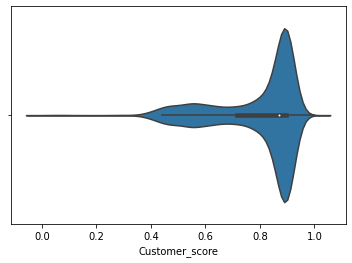

In [ ]:
sns.violinplot(x='Customer_score', data=Full_scores.toPandas())

Text(0, 0.5, 'Distribution (Between 0 & 1)')

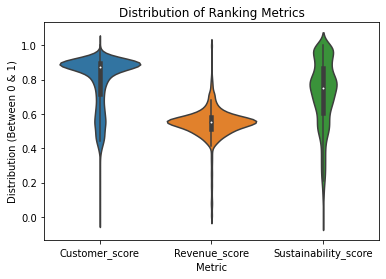

In [ ]:
Full_scores = Full_scores.withColumnRenamed('Merchant_score', 'Sustainability_score')
sns.violinplot(data=Full_scores.select('Customer_score', 'Revenue_score', 'Sustainability_score').toPandas())
plt.title('Distribution of Ranking Metrics')
plt.xlabel('Metric')
plt.ylabel('Distribution (Between 0 & 1)')


# Top 10

In [ ]:
top_100_pd = top_100.orderBy('total').limit(10)

In [ ]:
top_100_pd = top_100_pd.toPandas()

In [ ]:
top_100_pd = top_100_pd.sort_values(by='total')

,merchant_abn,Customer_score,Revenue_score,Merchant_score,total,sector
0,24852446429,0.000000,0.206028,0.204711,0.410739,Administrative_Support_Services
1,43186523025,0.093969,0.077551,0.247475,0.418995,Administrative_Support_Services
2,86578477987,0.002165,0.000799,0.666151,0.669114,Personal_Services
3,45629217853,0.062840,0.004821,0.684570,0.752231,Personal_Services
4,89726005175,0.071851,0.018109,0.693644,0.783605,Personal_Services
5,49891706470,0.058646,0.070159,0.674258,0.803063,Personal_Services
6,21439773999,0.242242,0.009179,0.626347,0.877769,Information_Media_Telecommunications
7,63290521567,0.198028,0.178919,0.539175,0.916122,Information_Media_Telecommunications
8,68216911708,0.157675,0.257834,0.540582,0.956090,Information_Media_Telecommunications
9,64203420245,0.038321,0.252930,0.668789,0.960040,Personal_Services


[Text(0, 0.5, 'Ranking Score')]

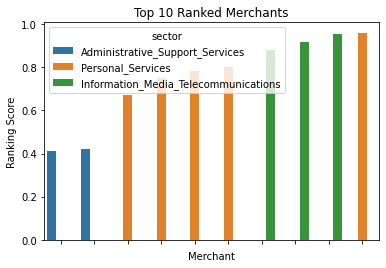

In [ ]:
plot_order = top_100_pd.sort_values(by='total').merchant_abn.values
plot = sns.barplot(x='merchant_abn', y='total', hue='sector', data=top_100_pd, order=plot_order)
plot.set(xticklabels=[])
plot.set(title='Top 10 Ranked Merchants')
plot.set(xlabel='Merchant')
plot.set(ylabel='Ranking Score')
